# Convert forecasts
This notebook is used to convert quantile forecasts to a parametric forecast that can be used as the input for the optimization process.

## Data Read-In

In [1]:
import inspect
import os

import pandas as pd
import numpy as np
import glob  as glob
import matplotlib.pyplot as plt
import scipy.optimize
from datetime import datetime
from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture
from scipy import stats
from scipy.stats import norm

In [2]:
path_forecast = '../data/quantile_forecasts/patch_tst_2025-03-20_07-14-26_prosumption_hour_6.csv'
path_gt = '../data/ground_truth/residential4_prosumption.csv'

def read_in_data(path):
    forecast = pd.read_csv(path, index_col=0, parse_dates=True)
    forecast.index = pd.to_datetime(forecast.index)
    return forecast

forecast = read_in_data(path_forecast)
forecast.columns = forecast.columns.str.replace('0_', '') # rename columns 0_0.01- 0_0.99 to 0.01 - 0.99
forecast.columns = forecast.columns.astype(float)

# Get the current date
current_date = datetime.now().strftime('%Y-%m-%d')

gt = read_in_data(path_gt)

## Visualization

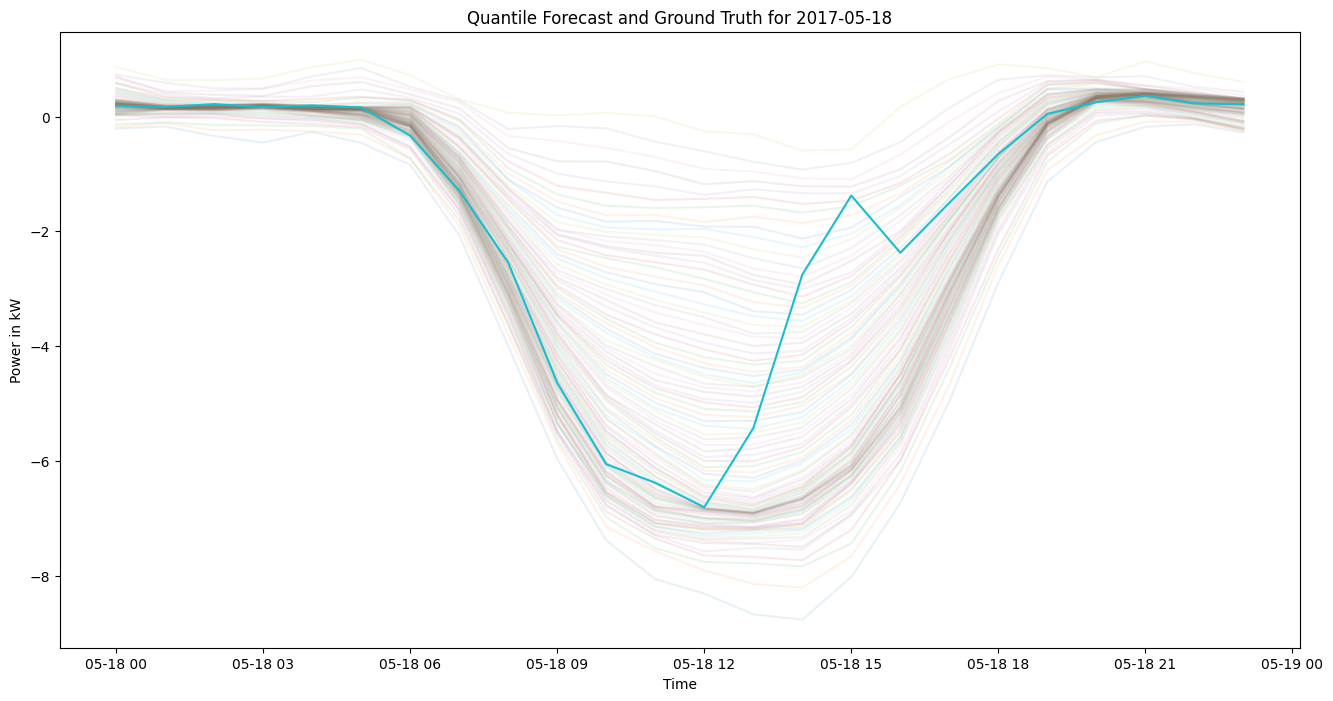

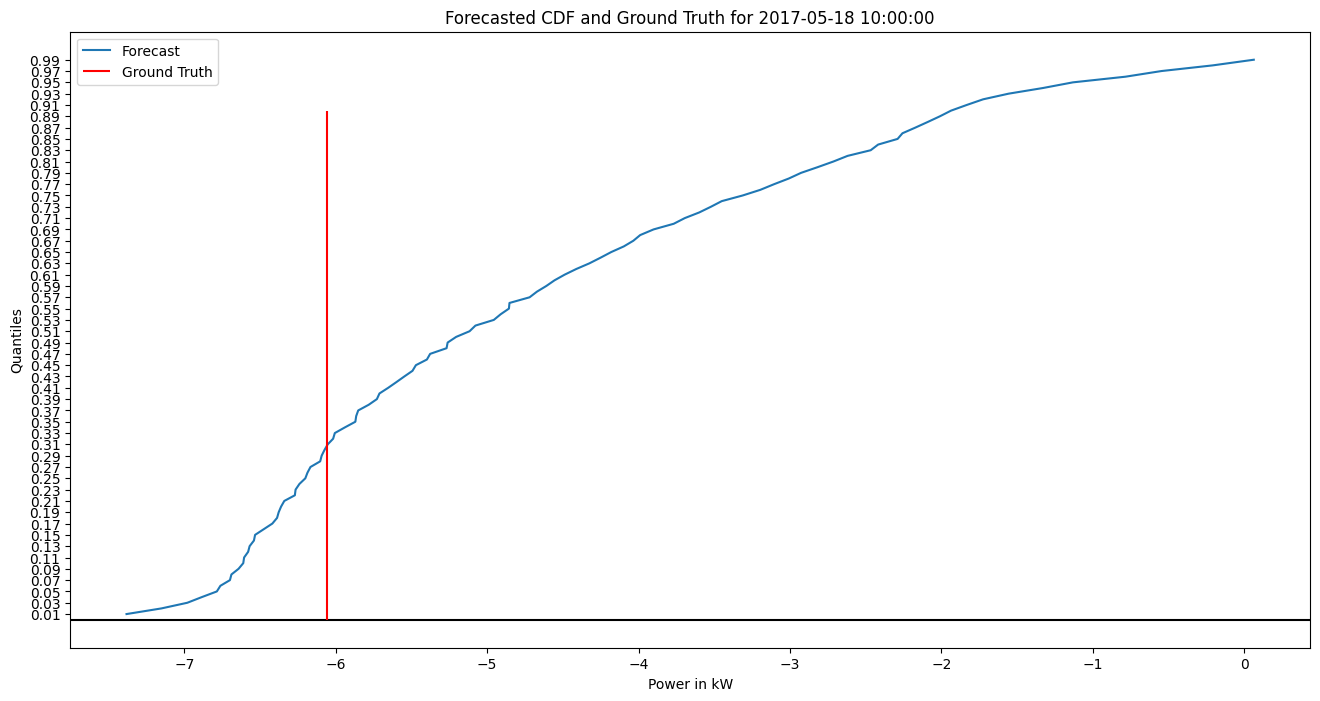

In [3]:
def plot_specific_day(fc_df, gt_df, day, title=None):
    plt.figure(figsize=(16,8))
    plt.plot(fc_df.loc[day], label='Forecast', alpha=0.1)
    plt.plot(gt_df.loc[day], label='Ground Truth', alpha=1)
    plt.ylabel('Power in kW')
    plt.xlabel('Time')
    if title is not None:
        plt.title(title)
    plt.show()

# create an viszualisation of every hour given a forecast containing the quantiles 0.01 to 0.99
def plot_forecast_hour(fc_df, gt_df, day_and_hour, title=None):
    plt.figure(figsize=(16,8))
    plt.plot(fc_df.loc[day_and_hour].values, fc_df.columns, label='Forecast', alpha=1)
    # plot the ground truth as horizontal line
    gt_value = gt_df.loc[day_and_hour].values[0]
    plt.axhline(y=0, color='k', linestyle='-')
    plt.vlines(x=gt_value, ymin=0, ymax=0.9, color='r', linestyle='-', label='Ground Truth')
    plt.ylabel('Quantiles')
    plt.yticks(np.arange(0.01, 1.01, 0.02))
    plt.xlabel('Power in kW')
    if title is not None:
        plt.title(title)   
    plt.legend()
    plt.show()


date_to_visualize = '2017-05-18'
date_time_to_visualize = date_to_visualize + ' 10:00:00'
plot_specific_day(forecast, gt, date_to_visualize, title=f'Quantile Forecast and Ground Truth for {date_to_visualize}')
plot_forecast_hour(forecast, gt, date_time_to_visualize, title=f'Forecasted CDF and Ground Truth for {date_time_to_visualize}')

## Sort the Quantiles

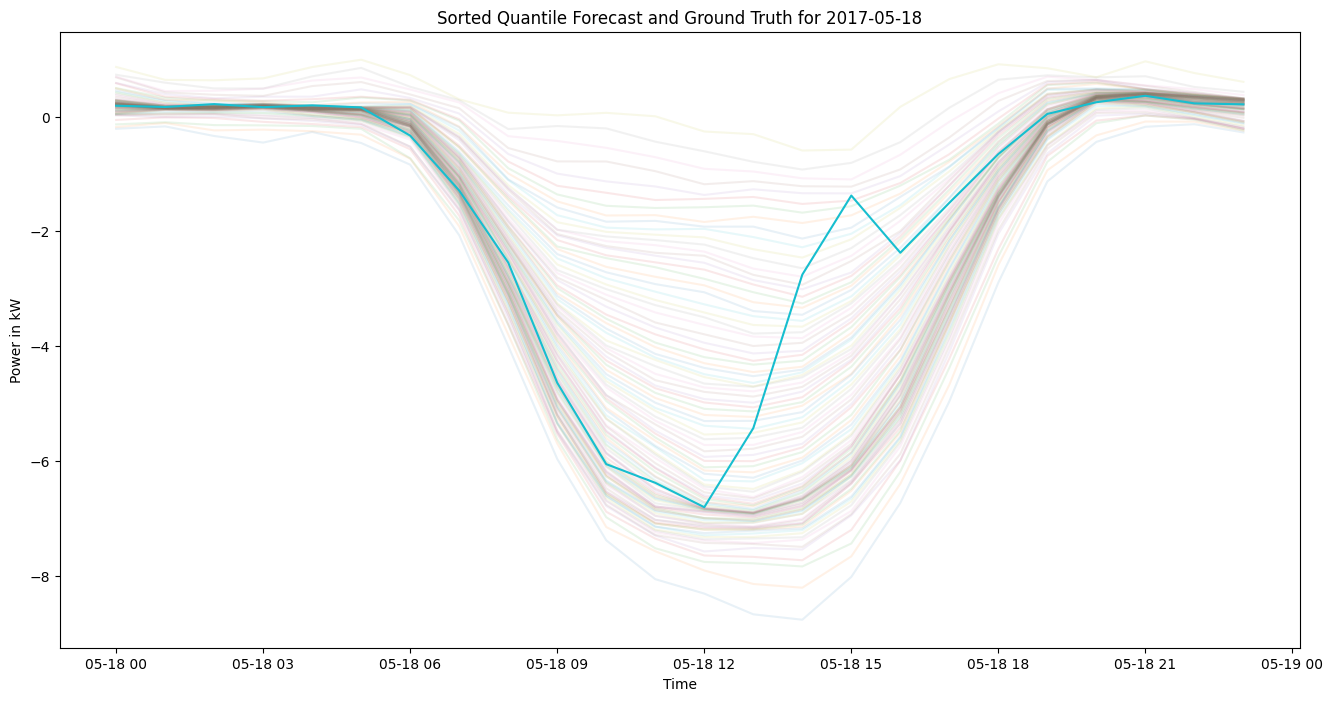

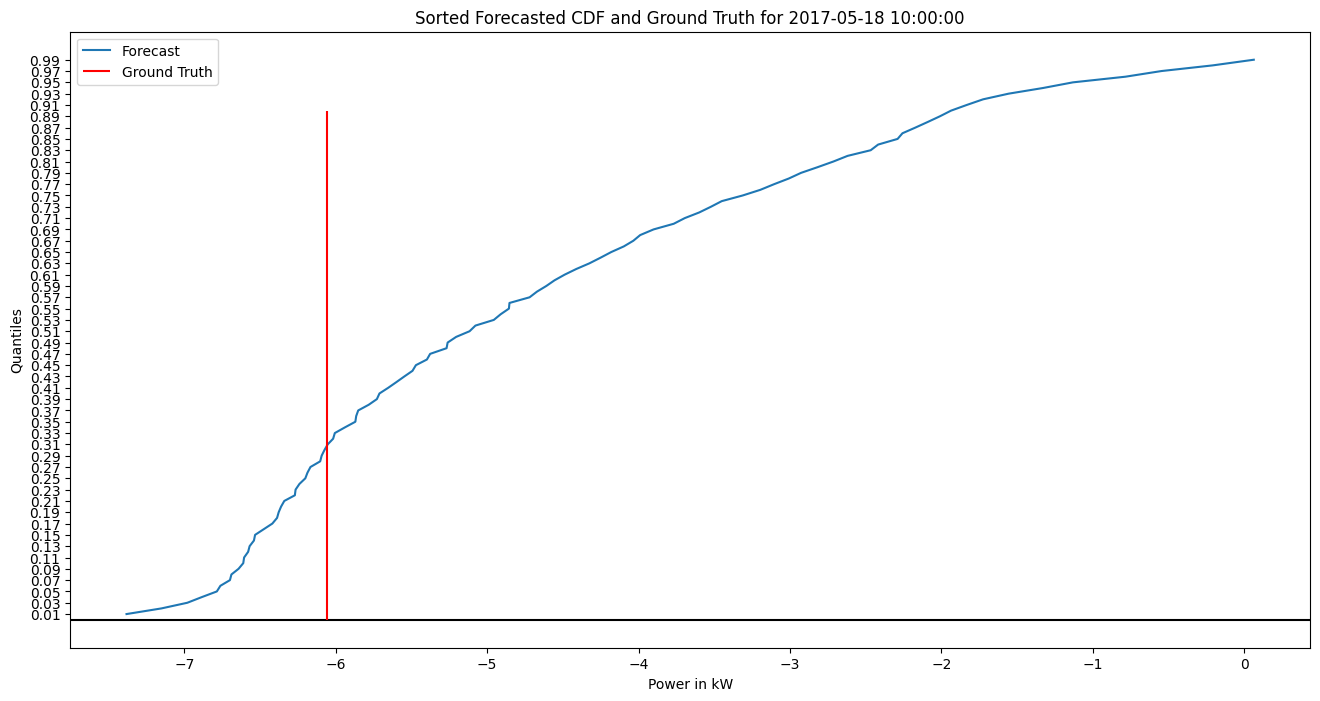

In [4]:
# go through every row of the dataframe and ensure that the values in ascending order (should be the case already => see np.quantile() docs)
def sort_quantiles(fc_df):
    fc_sorted = []
    for index, row in fc_df.iterrows():
        # sort the values in ascending order
        sorted_values = row.sort_values()
        fc_sorted.append(sorted_values.values)
    return pd.DataFrame(fc_sorted, index=fc_df.index, columns=fc_df.columns)

forecast_sorted = sort_quantiles(forecast)

# plot the sorted forecast
plot_specific_day(forecast_sorted, gt, date_to_visualize, title=f'Sorted Quantile Forecast and Ground Truth for {date_to_visualize}')
plot_forecast_hour(forecast_sorted, gt, date_time_to_visualize, title=f'Sorted Forecasted CDF and Ground Truth for {date_time_to_visualize}')

## Smooth the quantiles

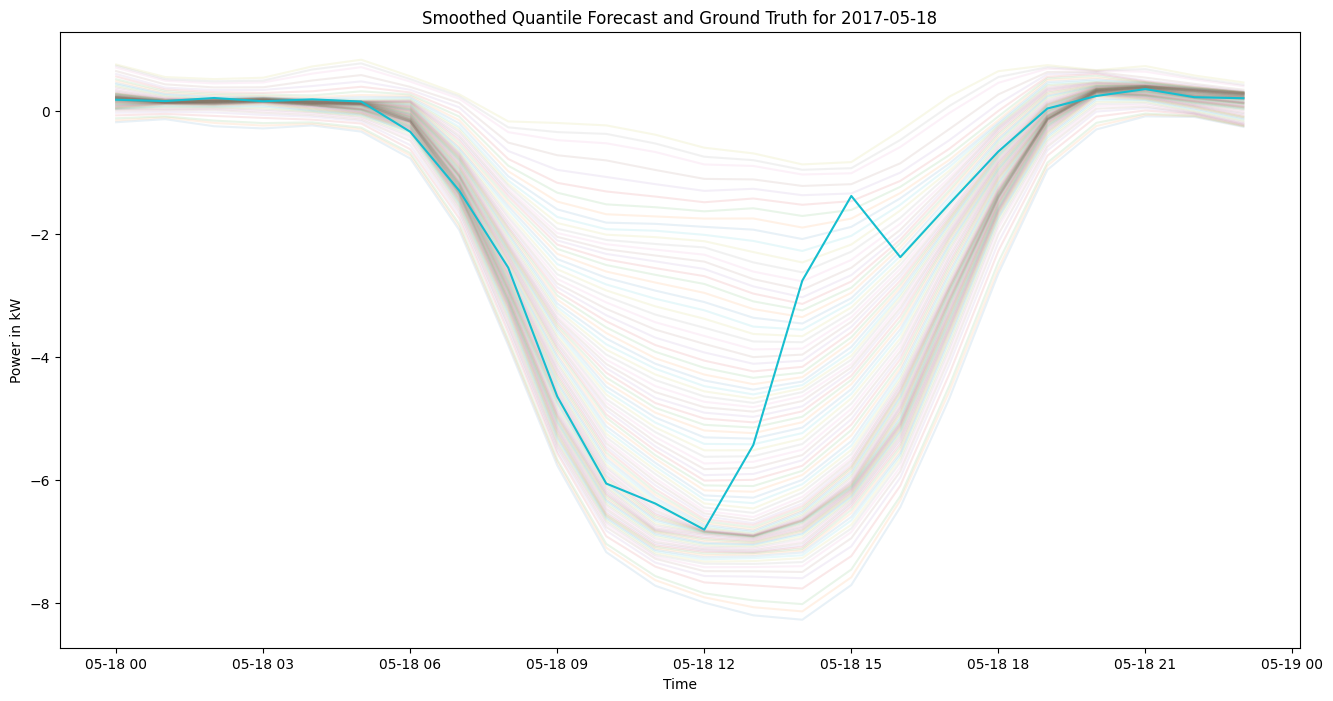

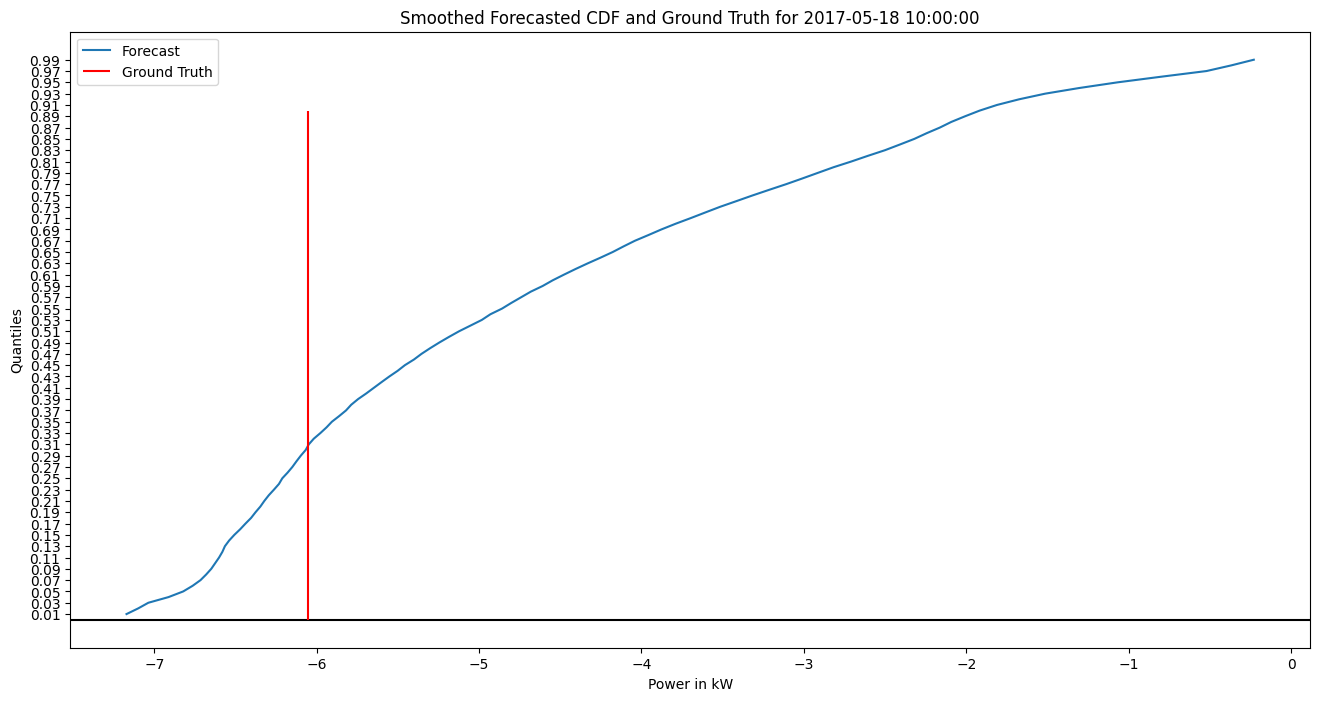

In [5]:
window_size = 5  # Paper: Window size of 5 was used
def smooth_quantiles(fc_df, window_size=5): 
    fc_smoothed = []
    for index, row in fc_df.iterrows():
        smoothed_values = row.rolling(window=window_size, min_periods=1, center=True).mean()
        fc_smoothed.append(smoothed_values.values)
    return pd.DataFrame(fc_smoothed, index=fc_df.index, columns=fc_df.columns)

forecast_smoothed = smooth_quantiles(forecast_sorted, window_size=window_size)

plot_specific_day(forecast_smoothed, gt, date_to_visualize, title=f'Smoothed Quantile Forecast and Ground Truth for {date_to_visualize}')
plot_forecast_hour(forecast_smoothed, gt, date_time_to_visualize, title=f'Smoothed Forecasted CDF and Ground Truth for {date_time_to_visualize}')

In [6]:
forecast_smoothed

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
cest_timestamp,,,,,,,,,,,,,,,,,,,,,
2017-04-28 06:00:00,0.057494,0.083017,0.106393,0.163709,0.188110,0.220897,0.259906,0.295821,0.331886,0.369590,...,0.942110,0.965219,1.003632,1.066516,1.127835,1.205891,1.328618,1.475066,1.533084,1.616843
2017-04-28 07:00:00,-0.890524,-0.828084,-0.772289,-0.649082,-0.590938,-0.539858,-0.499434,-0.475365,-0.453288,-0.429304,...,0.805732,0.855165,0.920542,0.999538,1.086318,1.182224,1.310878,1.483298,1.561811,1.652857
2017-04-28 08:00:00,-2.612091,-2.519740,-2.459602,-2.303444,-2.213748,-2.141684,-2.092522,-2.045866,-2.000667,-1.973720,...,0.332408,0.403674,0.475334,0.592335,0.748414,0.960330,1.181758,1.412771,1.530104,1.654221
2017-04-28 09:00:00,-4.226664,-4.116880,-4.025067,-3.850755,-3.706645,-3.614576,-3.543273,-3.495844,-3.453778,-3.420035,...,0.217233,0.279607,0.358465,0.478918,0.616592,0.781484,0.971477,1.262736,1.384839,1.511641
2017-04-28 10:00:00,-5.328229,-5.194767,-5.078916,-4.841948,-4.647202,-4.530359,-4.432968,-4.366220,-4.284665,-4.237459,...,0.346325,0.404889,0.490055,0.584288,0.711709,0.857003,1.052253,1.325400,1.454160,1.597213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-05 01:00:00,0.300851,0.338047,0.372819,0.427997,0.479864,0.507465,0.529208,0.539028,0.551100,0.561034,...,1.344755,1.392967,1.443657,1.495049,1.557819,1.637837,1.726151,1.823272,1.881457,1.935162
2018-02-05 02:00:00,0.278335,0.319250,0.344492,0.414231,0.459777,0.489013,0.517026,0.544998,0.564506,0.584013,...,1.348434,1.389981,1.432925,1.493126,1.573451,1.668459,1.758028,1.866342,1.919472,1.971371
2018-02-05 03:00:00,0.257222,0.284065,0.316054,0.388870,0.432619,0.464356,0.497141,0.518174,0.539248,0.555502,...,1.300055,1.333020,1.368912,1.411225,1.454105,1.523000,1.598426,1.698466,1.748444,1.813269


## Fit to normal distribution

In [7]:
def get_param_names(cdf):
    sig = inspect.signature(cdf._cdf)
    param_names = list(sig.parameters.keys())
    return param_names

def fit_distribution(df_row, cdf, num_params, quantiles, verbose=False):
    if quantiles is None:
        quantiles = np.linspace(0.01, 0.99, 99)
    y = df_row.values
    f = lambda y, *params: cdf(*params).cdf(y)
    params, _ = scipy.optimize.curve_fit(f, y, quantiles, p0=[1]*num_params, maxfev=20000)
    if verbose:
        plt.plot(y, quantiles, 'o')
        plt.plot(y, f(y, *params))
        plt.show()  
    return params

def fit_distributions(fc_df, cdf, num_params, quantiles=None):
    fc_fitted = []
    for index, row in fc_df.iterrows():
        params = fit_distribution(row, cdf, num_params, quantiles)
        fc_fitted.append(params)

    #print(get_param_names(cdf))
    columns = [f'param_{i}' for i in range(num_params)]
    return pd.DataFrame(fc_fitted, index=fc_df.index, columns=columns)

In [8]:
# fit to normal distribution
norm = scipy.stats.norm
#forecast_fitted = fit_distributions(forecast_smoothed, norm, 2)
forecast_fitted = fit_distributions(forecast_smoothed.loc['2017-04-01':'2018-02-20'], norm, 2)

In [9]:
# separate the forecast into expected value forecast and standard deviation forecast
# NORMAL DISTRIBUTION
forecast_exp_values = forecast_fitted['param_0']
forecast_variance = forecast_fitted.copy()
forecast_variance['param_0'] = 0.0

# Save the forecasts to use as input for the optimization
folder_name = f'normal_dist_forecast_{current_date}'
os.makedirs('../data/parametric_forecasts/' + folder_name, exist_ok=True)

forecast_exp_values.to_csv(f'../data/parametric_forecasts/{folder_name}/expected_value_forecast.csv')
forecast_variance.to_csv(f'../data/parametric_forecasts/{folder_name}/cdf_weights.csv')

## Fit to Gaussian Mixture Model with 2 components (gmm2)

In [11]:
# Create the GMM forecasts
gmm_timerange = ['2017-04-01', '2018-02-20']
forecast_gmm = forecast_smoothed.loc[gmm_timerange[0] : gmm_timerange[1]].copy()

weights_gmm = []

quantile_levels = forecast_gmm.columns.astype(float)  # Quantile levels (e.g., 1% to 99%)
for t, quantile_values in forecast_gmm.iterrows():

    # Step 1: Create an interpolator to map quantile levels to quantile values
    inv_cdf = interp1d(quantile_levels, quantile_values, kind='linear', fill_value="extrapolate")

    # Step 2: Generate synthetic samples via interpolation 
    #         Scipy only allows fitting to the PDF, not the CDF. Thus, we sample a PDF based on the estimated Quantile values
    np.random.seed(42)
    synthetic_x = np.random.uniform(0.0, 1.0, 20000)
    synthetic_samples = inv_cdf(synthetic_x)  # Generate aritificial quantile value samples

    # Step 3: Fit GMM to synthetic samples
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42, reg_covar=1e-4)
    gmm.fit(synthetic_samples.reshape(-1, 1))

    # Extract parameters
    weights = gmm.weights_
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()

    # Transform variance to standard deviation
    standard_devs = np.sqrt(variances)
    weights_gmm.append([weights[0], means[0], standard_devs[0], weights[1], means[1], standard_devs[1]])


# Create a dataframe with the GMM weights
columns = ['w1', 'mu1', 'std1', 'w2', 'mu2', 'std2']

df_weights_gmm = pd.DataFrame(weights_gmm, index=forecast_gmm.index, columns=columns)


# Extract the expected values from the GMM weights and shift the GMM fits to have an expected value of 0
weights_gmm_shifted = []
expected_vals_gmm = []

for t, weights in df_weights_gmm.iterrows():
    w1, mu1, std1, w2, mu2, std2 = weights
    expected_value = w1 * mu1 + w2 * mu2
    mu1_shifted = mu1 - expected_value
    mu2_shifted = mu2 - expected_value
    weights_gmm_shifted.append([w1, mu1_shifted, std1, w2, mu2_shifted, std2])
    expected_vals_gmm.append([expected_value])

df_weights_gmm_shifted = pd.DataFrame(weights_gmm_shifted, index=df_weights_gmm.index, columns=columns)
df_exp_val_gmm = pd.DataFrame(expected_vals_gmm, index=df_weights_gmm.index, columns=['expected_value'])

In [13]:
# save the GMM forecasts 
folder_name = f'gmm2_forecast_{current_date}_WindowSize{window_size}_patch_tst_prosumption_10_03_2025'
os.makedirs('../data/parametric_forecasts/' + folder_name, exist_ok=True)

df_exp_val_gmm.to_csv(f'../data/parametric_forecasts/{folder_name}/expected_value_forecast.csv')
df_weights_gmm_shifted.to_csv(f'../data/parametric_forecasts/{folder_name}/cdf_weights.csv')